# Question 2.8 : DQN Adapté pour la Classification

Ce notebook implémente un **DQN adapté** pour résoudre la **même tâche de classification** que l'apprentissage supervisé.

## Objectif
Adapter l'agent DQN pour prédire la direction du prix du Bitcoin (BAISSE/STABLE/HAUSSE) afin de permettre une **comparaison directe** avec l'approche supervisée.

## Différences clés avec le DQN de trading (Q2.4)
| Aspect | DQN Trading (Q2.4) | DQN Classification (Q2.8) |
|--------|-------------------|---------------------------|
| **Tâche** | Maximiser le profit | Prédire la direction correctement |
| **Actions** | Hold/Buy/Sell (gestion portefeuille) | Prédire BAISSE/STABLE/HAUSSE |
| **État** | 5 features (avec position + solde) | 3 features (log_ret, rsi, macd) |
| **Récompense** | Variation du portefeuille ($V_t - V_{t-1}$) | +1 si correct, -1 si incorrect |
| **Épisode** | Tout l'historique (2158 jours) | 1 prédiction = 1 step |

## Approche
L'agent apprend par **essai-erreur** à prédire la bonne classe en maximisant les récompenses correctes.

## 1. Importation des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from ta.momentum import RSIIndicator
from ta.trend import MACD
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Configuration pour la reproductibilité
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## 2. Chargement et Préparation des Données

Nous utilisons **exactement les mêmes données** que pour l'apprentissage supervisé.

In [2]:
def get_bitcoin_data():
    """
    Télécharge et prépare les données Bitcoin avec labels de classification.
    Identique à l'approche supervisée.
    """
    print("Téléchargement des données Bitcoin...")
    df = yf.download('BTC-USD', start='2018-01-01', end='2024-01-01', interval='1d')
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df = df.astype('float32')
    df = df.dropna()
    close_series = df['Close'].squeeze()

    # Calcul des indicateurs techniques
    df['log_ret'] = np.log(close_series / close_series.shift(1))
    
    rsi = RSIIndicator(close=close_series, window=14)
    df['rsi'] = rsi.rsi() / 100.0
    
    macd = MACD(close=close_series)
    df['macd'] = macd.macd_diff()
    
    # Rendement futur pour créer les labels
    df['future_return'] = df['log_ret'].shift(-1)
    
    df = df.dropna().astype('float32')
    
    # Création des labels de classification (0=BAISSE, 1=STABLE, 2=HAUSSE)
    threshold = 0.005
    conditions = [
        df['future_return'] < -threshold,
        (df['future_return'] >= -threshold) & (df['future_return'] <= threshold),
        df['future_return'] > threshold
    ]
    df['label'] = np.select(conditions, [0, 1, 2])
    
    print(f"Données prêtes : {len(df)} jours")
    print(f"\nDistribution des classes :")
    print(f"  0 (BAISSE) : {(df['label'] == 0).sum()} jours ({100 * (df['label'] == 0).sum() / len(df):.1f}%)")
    print(f"  1 (STABLE) : {(df['label'] == 1).sum()} jours ({100 * (df['label'] == 1).sum() / len(df):.1f}%)")
    print(f"  2 (HAUSSE) : {(df['label'] == 2).sum()} jours ({100 * (df['label'] == 2).sum() / len(df):.1f}%)")
    
    return df

df = get_bitcoin_data()

Téléchargement des données Bitcoin...


C:\Users\leona\AppData\Local\Temp\ipykernel_25864\3066914696.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start='2018-01-01', end='2024-01-01', interval='1d')
[*********************100%***********************]  1 of 1 completed

Données prêtes : 2157 jours

Distribution des classes :
  0 (BAISSE) : 811 jours (37.6%)
  1 (STABLE) : 473 jours (21.9%)
  2 (HAUSSE) : 873 jours (40.5%)


## 3. Environnement de Classification pour le DQN

**Différence majeure** : L'environnement ne gère plus un portefeuille, mais évalue simplement si la prédiction est correcte.

In [7]:
class ClassificationEnv:
    """
    Environnement pour la classification avec DQN.
    
    État : [log_ret, rsi, macd] (3 features)
    Actions : 0=Prédire BAISSE, 1=Prédire STABLE, 2=Prédire HAUSSE
    Récompense : +1 si correct, -1 si incorrect
    """
    def __init__(self, df, train=True):
        self.df = df.reset_index(drop=True)
        self.feature_columns = ['log_ret', 'rsi', 'macd']
        
        # Séparation train/test (80/20)
        split_idx = int(0.8 * len(self.df))
        if train:
            self.df = self.df.iloc[:split_idx].reset_index(drop=True)
        else:
            self.df = self.df.iloc[split_idx:].reset_index(drop=True)
        
        self.n_samples = len(self.df)
        self.reset()
        
        print(f"\nEnvironnement {'TRAIN' if train else 'TEST'} créé : {self.n_samples} observations")
    
    def reset(self):
        """
        Réinitialise l'environnement au début.
        """
        self.current_step = 0
        self.correct_predictions = 0
        self.total_predictions = 0
        return self._get_observation()
    
    def _get_observation(self):
        """
        Retourne l'état actuel : vecteur de 3 features.
        """
        obs = self.df.iloc[self.current_step][self.feature_columns].values.astype('float32')
        return obs
    
    def step(self, action):
        """
        Exécute une action (prédiction) et retourne (état_suivant, récompense, terminé).
        
        Args:
            action : 0, 1, ou 2 (classe prédite)
        
        Returns:
            next_state : Prochain état
            reward : +1 si correct, -1 si incorrect
            done : True si fin de l'épisode
        """
        # Récupérer la vraie classe
        true_label = int(self.df.iloc[self.current_step]['label'])
        
        # Calculer la récompense
        if action == true_label:
            reward = 1.0  # Bonne prédiction
            self.correct_predictions += 1
        else:
            reward = -1.0  # Mauvaise prédiction
        
        self.total_predictions += 1
        
        # Avancer au step suivant
        self.current_step += 1
        
        # Vérifier si terminé
        done = self.current_step >= self.n_samples
        
        if done:
            # Si terminé, on retourne un état de zéros car current_step est hors limites
            next_state = np.zeros(len(self.feature_columns), dtype='float32')
        else:
            next_state = self._get_observation()
        
        return next_state, reward, done
    
    def get_accuracy(self):
        """
        Retourne l'accuracy courante de l'épisode.
        """
        if self.total_predictions == 0:
            return 0.0
        return 100 * self.correct_predictions / self.total_predictions

# Création des environnements train et test
env_train = ClassificationEnv(df, train=True)
env_test = ClassificationEnv(df, train=False)


Environnement TRAIN créé : 1725 observations

Environnement TEST créé : 432 observations


## 4. Architecture du DQN (Identique au Supervisé)

Pour une comparaison équitable, nous utilisons **exactement la même architecture** : 3 → 64 → 32 → 3

In [4]:
class DQN(nn.Module):
    """
    Réseau de neurones pour le DQN.
    Architecture identique au modèle supervisé : 3 -> 64 -> 32 -> 3
    """
    def __init__(self, input_dim=3, output_dim=3):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Propagation avant.
        Sortie : Q-values pour les 3 actions (classes).
        """
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)  # Q-values

# Instanciation
policy_net = DQN(input_dim=3, output_dim=3)
target_net = DQN(input_dim=3, output_dim=3)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

print("\nArchitecture du DQN :")
print(policy_net)
print(f"\nNombre de paramètres : {sum(p.numel() for p in policy_net.parameters())}")


Architecture du DQN :
DQN(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)

Nombre de paramètres : 2435


## 5. Hyperparamètres et Configuration

Nous gardons des hyperparamètres similaires au DQN de trading pour la cohérence.

In [5]:
# Hyperparamètres
EPISODES = 100           # Nombre d'époques (équivalent aux époques supervisées)
BATCH_SIZE = 64         # Taille du batch
GAMMA = 0.95            # Facteur de discount (importance du futur)
EPSILON = 1.0           # Exploration initiale
EPSILON_MIN = 0.01      # Exploration minimale
EPSILON_DECAY = 0.995   # Décroissance de l'exploration
LEARNING_RATE = 0.001   # Taux d'apprentissage (identique au supervisé)
MEMORY_SIZE = 10000     # Taille du replay buffer
TARGET_UPDATE = 10      # Fréquence de mise à jour du target network

# Mémoire de répétition
memory = deque(maxlen=MEMORY_SIZE)

# Optimiseur et fonction de perte
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

print("Configuration :")
print(f"  Épisodes : {EPISODES}")
print(f"  Batch size : {BATCH_SIZE}")
print(f"  Learning rate : {LEARNING_RATE}")
print(f"  Gamma : {GAMMA}")
print(f"  Epsilon : {EPSILON} → {EPSILON_MIN} (decay {EPSILON_DECAY})")

Configuration :
  Épisodes : 100
  Batch size : 64
  Learning rate : 0.001
  Gamma : 0.95
  Epsilon : 1.0 → 0.01 (decay 0.995)


## 6. Boucle d'Entraînement du DQN

**Principe** : L'agent apprend à maximiser les récompenses correctes (+1) en minimisant les erreurs (-1).

In [9]:
def train_dqn_classification():
    """
    Entraîne le DQN pour la tâche de classification.
    """
    global EPSILON
    
    history = {
        'train_accuracy': [],
        'test_accuracy': [],
        'train_reward': [],
        'epsilon': []
    }
    
    print("\nDébut de l'entraînement DQN pour classification...\n")
    start_time = time.time()
    
    for episode in range(EPISODES):
        # === PHASE D'ENTRAÎNEMENT ===
        state = env_train.reset()
        state = torch.FloatTensor(state)
        done = False
        episode_reward = 0
        
        while not done:
            # Sélection d'action (epsilon-greedy)
            if random.random() < EPSILON:
                action = random.randint(0, 2)  # Exploration
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                    action = torch.argmax(q_values).item()  # Exploitation
            
            # Exécution de l'action
            next_state, reward, done = env_train.step(action)
            next_state = torch.FloatTensor(next_state)
            episode_reward += reward
            
            # Stockage dans la mémoire
            memory.append((state, action, reward, next_state, done))
            state = next_state
            
            # Apprentissage (si assez de données)
            if len(memory) >= BATCH_SIZE:
                batch = random.sample(memory, BATCH_SIZE)
                
                states = torch.stack([x[0] for x in batch])
                actions = torch.tensor([x[1] for x in batch]).unsqueeze(1)
                rewards = torch.tensor([x[2] for x in batch], dtype=torch.float32)
                next_states = torch.stack([x[3] for x in batch])
                dones = torch.tensor([x[4] for x in batch], dtype=torch.bool)
                
                # Q-values actuelles
                q_values = policy_net(states).gather(1, actions).squeeze()
                
                # Q-values cibles (avec target network)
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    next_q_values[dones] = 0.0
                    target_q_values = rewards + GAMMA * next_q_values
                
                # Calcul de la perte et mise à jour
                loss = criterion(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Mise à jour du target network
        if episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        # Décroissance d'epsilon
        if EPSILON > EPSILON_MIN:
            EPSILON *= EPSILON_DECAY
        
        # Évaluation sur l'ensemble de test
        test_accuracy = evaluate_dqn(env_test, policy_net)
        train_accuracy = env_train.get_accuracy()
        
        # Enregistrement de l'historique
        history['train_accuracy'].append(train_accuracy)
        history['test_accuracy'].append(test_accuracy)
        history['train_reward'].append(episode_reward)
        history['epsilon'].append(EPSILON)
        
        # Affichage tous les 5 épisodes
        if (episode + 1) % 5 == 0 or episode == 0:
            print(f"Épisode [{episode+1:3d}/{EPISODES}] | "
                  f"Train Acc: {train_accuracy:.2f}% | "
                  f"Test Acc: {test_accuracy:.2f}% | "
                  f"Reward: {episode_reward:+.0f} | "
                  f"Epsilon: {EPSILON:.3f}")
    
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"\nEntraînement terminé en {training_time:.2f} secondes ({training_time/60:.2f} minutes)")
    
    return history, training_time

def evaluate_dqn(env, model):
    """
    Évalue le DQN sur un environnement (sans exploration).
    """
    model.eval()
    state = env.reset()
    done = False
    
    with torch.no_grad():
        while not done:
            state_tensor = torch.FloatTensor(state)
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()
            state, _, done = env.step(action)
    
    model.train()
    return env.get_accuracy()

# Lancement de l'entraînement
history, training_time = train_dqn_classification()


Début de l'entraînement DQN pour classification...

Épisode [  1/100] | Train Acc: 34.67% | Test Acc: 32.41% | Reward: -529 | Epsilon: 0.869
Épisode [  5/100] | Train Acc: 35.25% | Test Acc: 33.33% | Reward: -509 | Epsilon: 0.852
Épisode [ 10/100] | Train Acc: 35.59% | Test Acc: 33.80% | Reward: -497 | Epsilon: 0.831
Épisode [ 15/100] | Train Acc: 34.90% | Test Acc: 32.87% | Reward: -521 | Epsilon: 0.810
Épisode [ 20/100] | Train Acc: 36.58% | Test Acc: 33.80% | Reward: -463 | Epsilon: 0.790
Épisode [ 25/100] | Train Acc: 35.13% | Test Acc: 32.64% | Reward: -513 | Epsilon: 0.771
Épisode [ 30/100] | Train Acc: 36.23% | Test Acc: 33.80% | Reward: -475 | Epsilon: 0.751
Épisode [ 35/100] | Train Acc: 36.35% | Test Acc: 32.87% | Reward: -471 | Epsilon: 0.733
Épisode [ 40/100] | Train Acc: 35.94% | Test Acc: 31.25% | Reward: -485 | Epsilon: 0.715
Épisode [ 45/100] | Train Acc: 38.26% | Test Acc: 34.49% | Reward: -405 | Epsilon: 0.697
Épisode [ 50/100] | Train Acc: 36.87% | Test Acc: 34.49% 

## 7. Évaluation Finale et Métriques Détaillées

Nous évaluons le DQN avec les **mêmes métriques** que l'apprentissage supervisé pour permettre la comparaison.

In [10]:
def detailed_evaluation(env, model):
    """
    Évaluation détaillée avec matrice de confusion et rapport de classification.
    """
    model.eval()
    state = env.reset()
    done = False
    
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        while not done:
            state_tensor = torch.FloatTensor(state)
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()
            
            # Récupérer le vrai label
            true_label = int(env.df.iloc[env.current_step - 1]['label'])  # -1 car step incrémente
            
            predictions.append(action)
            true_labels.append(true_label)
            
            state, _, done = env.step(action)
    
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    # Calcul des métriques
    accuracy = accuracy_score(true_labels, predictions)
    cm = confusion_matrix(true_labels, predictions)
    
    print("\n" + "="*60)
    print("RÉSULTATS FINAUX - DQN CLASSIFICATION")
    print("="*60)
    
    print(f"\nAccuracy (Test) : {accuracy*100:.2f}%")
    print(f"Temps d'entraînement : {training_time:.2f} secondes")
    
    print("\nMatrice de Confusion :")
    print(cm)
    print("(Lignes = Vraies classes, Colonnes = Prédictions)")
    
    print("\nRapport de Classification :")
    target_names = ['BAISSE (0)', 'STABLE (1)', 'HAUSSE (2)']
    print(classification_report(true_labels, predictions, target_names=target_names))
    
    model.train()
    return predictions, true_labels, accuracy, cm

# Évaluation détaillée sur le test
predictions, true_labels, final_accuracy, cm = detailed_evaluation(env_test, policy_net)


RÉSULTATS FINAUX - DQN CLASSIFICATION

Accuracy (Test) : 28.94%
Temps d'entraînement : 1049.61 secondes

Matrice de Confusion :
[[64  2 69]
 [73  5 73]
 [89  1 56]]
(Lignes = Vraies classes, Colonnes = Prédictions)

Rapport de Classification :
              precision    recall  f1-score   support

  BAISSE (0)       0.28      0.47      0.35       135
  STABLE (1)       0.62      0.03      0.06       151
  HAUSSE (2)       0.28      0.38      0.33       146

    accuracy                           0.29       432
   macro avg       0.40      0.30      0.25       432
weighted avg       0.40      0.29      0.24       432



## 8. Visualisation des Résultats

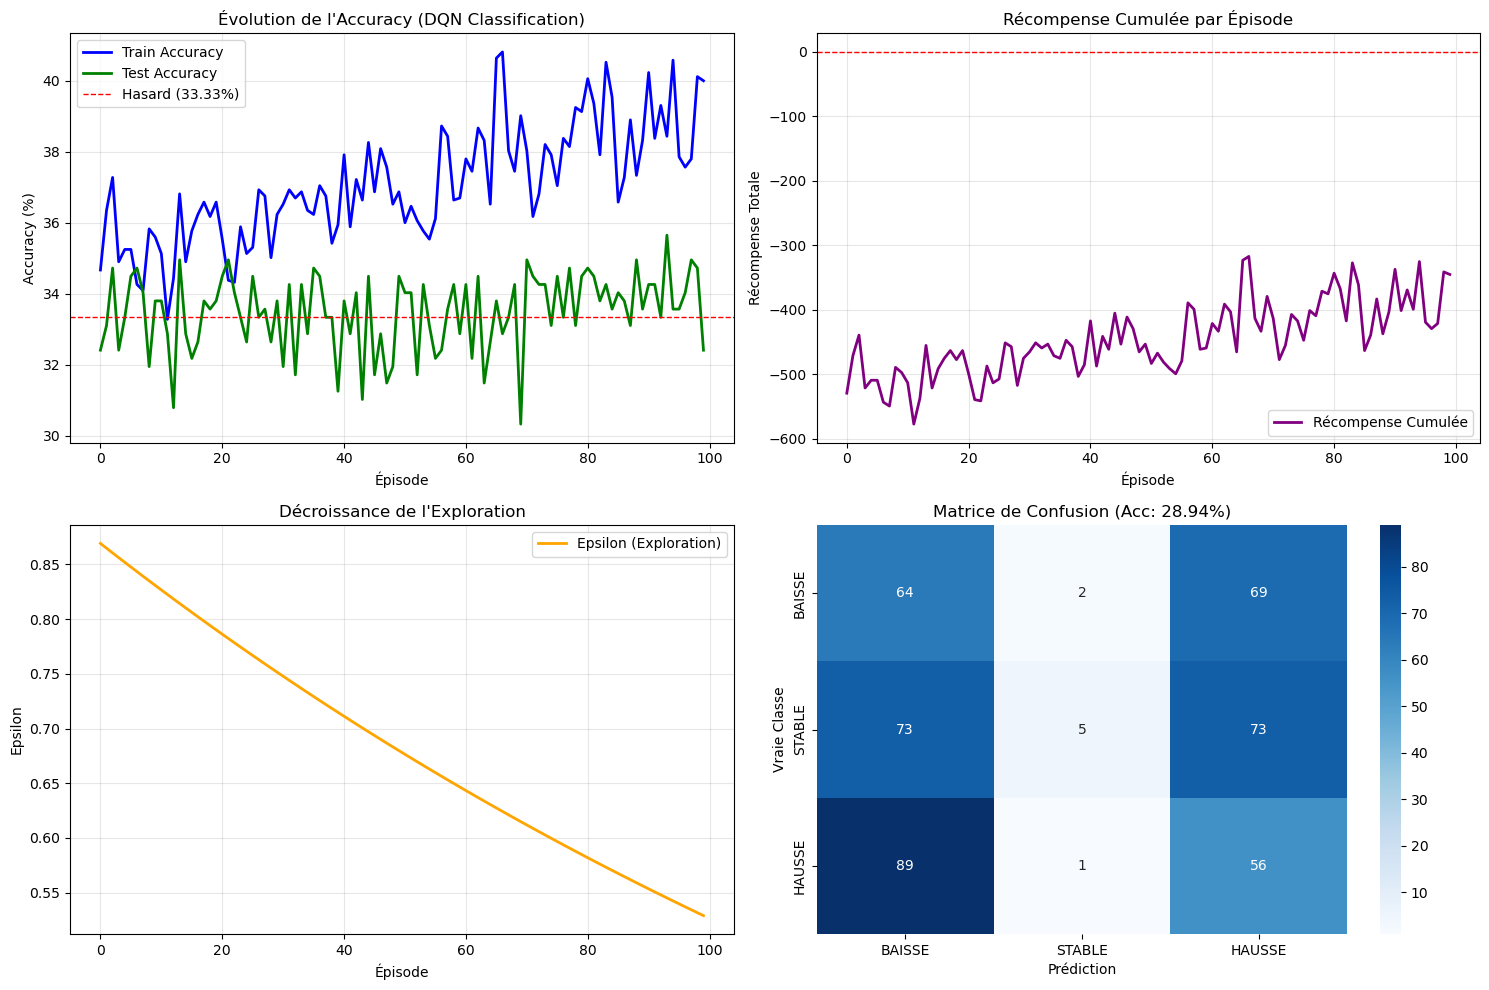


Graphique sauvegardé : dqn_classification_results.png


In [12]:
# === GRAPHIQUE 1 : Courbes d'Apprentissage ===
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Sous-graphique 1 : Accuracy Train vs Test
ax1.plot(history['train_accuracy'], label='Train Accuracy', color='blue', linewidth=2)
ax1.plot(history['test_accuracy'], label='Test Accuracy', color='green', linewidth=2)
ax1.axhline(y=33.33, color='red', linestyle='--', linewidth=1, label='Hasard (33.33%)')
ax1.set_xlabel('Épisode')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Évolution de l\'Accuracy (DQN Classification)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sous-graphique 2 : Récompense par épisode
ax2.plot(history['train_reward'], label='Récompense Cumulée', color='purple', linewidth=2)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax2.set_xlabel('Épisode')
ax2.set_ylabel('Récompense Totale')
ax2.set_title('Récompense Cumulée par Épisode')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Sous-graphique 3 : Décroissance d'Epsilon
ax3.plot(history['epsilon'], label='Epsilon (Exploration)', color='orange', linewidth=2)
ax3.set_xlabel('Épisode')
ax3.set_ylabel('Epsilon')
ax3.set_title('Décroissance de l\'Exploration')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Sous-graphique 4 : Matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['BAISSE', 'STABLE', 'HAUSSE'],
            yticklabels=['BAISSE', 'STABLE', 'HAUSSE'])
ax4.set_xlabel('Prédiction')
ax4.set_ylabel('Vraie Classe')
ax4.set_title(f'Matrice de Confusion (Acc: {final_accuracy*100:.2f}%)')

plt.tight_layout()
plt.savefig('dqn_classification_results.png', dpi=300)
plt.show()

print("\nGraphique sauvegardé : dqn_classification_results.png")

## 9. Comparaison avec l'Apprentissage Supervisé

Chargeons les résultats de l'apprentissage supervisé pour la comparaison.

In [16]:
import pickle

# Chargement des résultats supervisés
try:
    with open('supervised_results.pkl', 'rb') as f:
        supervised_results = pickle.load(f)
    
    print("\n" + "="*70)
    print("COMPARAISON : DQN vs SUPERVISÉ (Question 2.9)")
    print("="*70)
    
    print("\nTÂCHE IDENTIQUE : Prédire la direction du Bitcoin (3 classes)\n")
    
    print("Métrique                     Supervisé        DQN")
    print("------------------------------------------------------")
    print(f"Accuracy Test (%)           {supervised_results['accuracy']*100:10.2f}     {final_accuracy*100:10.2f}")
    print(f"Temps d'entraînement (s)    {supervised_results['training_time']:10.2f}     {training_time:10.2f}")

    # Calcul du ratio de vitesse
    speedup = training_time / supervised_results['training_time']
    print(f"Ratio de vitesse            {1.0:10.2f}x    {speedup:10.2f}x")

    # Analyse qualitative
    print("\nANALYSE :")
    
    acc_diff = final_accuracy - supervised_results['accuracy']
    if abs(acc_diff) < 0.02:
        print(f"  - Performances SIMILAIRES (écart de {abs(acc_diff)*100:.1f}%)")
    elif acc_diff > 0:
        print(f"  - DQN MEILLEUR de {acc_diff*100:.1f}%")
    else:
        print(f"  - Supervisé MEILLEUR de {abs(acc_diff)*100:.1f}%")
    
    if speedup > 1:
        print(f"  - DQN est {speedup:.1f}× PLUS LENT que le supervisé")
    else:
        print(f"  - DQN est {1/speedup:.1f}× PLUS RAPIDE que le supervisé")
    
    print(f"\n  - Les deux approches ont une accuracy proche du hasard (33.33%)")
    print(f"  - Cela confirme que la prédiction directionnelle du Bitcoin est très difficile.")
    
except FileNotFoundError:
    print("Fichier supervised_results.pkl non trouvé. Exécutez d'abord train_supervised.ipynb")


COMPARAISON : DQN vs SUPERVISÉ (Question 2.9)

TÂCHE IDENTIQUE : Prédire la direction du Bitcoin (3 classes)

Métrique                     Supervisé        DQN
------------------------------------------------------
Accuracy Test (%)                32.64          28.94
Temps d'entraînement (s)         14.39        1049.61
Ratio de vitesse                  1.00x         72.96x

ANALYSE :
  - Supervisé MEILLEUR de 3.7%
  - DQN est 73.0× PLUS LENT que le supervisé

  - Les deux approches ont une accuracy proche du hasard (33.33%)
  - Cela confirme que la prédiction directionnelle du Bitcoin est très difficile.


## 10. Sauvegarde des Résultats

In [17]:
# Sauvegarde du modèle
torch.save(policy_net.state_dict(), 'dqn_classification_model.pth')
print("\nModèle sauvegardé : dqn_classification_model.pth")

# Sauvegarde des résultats
dqn_results = {
    'accuracy': final_accuracy,
    'training_time': training_time,
    'history': history,
    'predictions': predictions,
    'true_labels': true_labels,
    'confusion_matrix': cm
}

with open('dqn_classification_results.pkl', 'wb') as f:
    pickle.dump(dqn_results, f)

print("Résultats sauvegardés : dqn_classification_results.pkl")


Modèle sauvegardé : dqn_classification_model.pth
Résultats sauvegardés : dqn_classification_results.pkl
